# Deep Learning Example with `tflearn`

<i>Michelle Lochner</i>

<i>(With lots of help from Boris Leistedt, Gilles Louppe and Christopher Bonnett)</i>

This notebook illustrates how to use `tflearn` (http://tflearn.org/) to create your own convolutional neural network (CNN) to run on your own dataset. 

This is an amalgamation of the  examples on Keras (https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py), the `tflearn` example (https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_mnist.py) with some added visualisation from https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb.

### A super brief introduction to CNNs

<b>Disclaimer</b>: I am not an expert on the theory of CNNs. None of the information below is guaranteed to be accurate. I will just add practical points, that I have figured out, to better understand how to make this algorithm work for your data.

These Stanford course notes http://cs231n.github.io/convolutional-networks/ are amazing, it doesn't take long to go through them and get a pretty good understanding of CNNs (and other neural nets too). I'll add a couple of images with descriptions from those notes to give you an idea of CNNs. Another really well-written resource is http://colah.github.io/posts/2014-07-Conv-Nets-Modular/.

<b>Structure of neural networks</b>

This is the basic structure of any neural network, which were invented to attempt to emulate the connections found in the brain. Essentially it learns a non-linear transformation which converts input to output. Like any machine learning algorithm, you train it on some training data with known output. The hidden layers are made up of "neurons", which connect to every feature of the input, performing said non-linear transforms. Each neuron has a weight and these are learned from training data. 

<img src="neural_net2.jpeg",style="width: 600px">

<b>What makes convolutional neural networks different?</b>

It's usually quite rare to get much benefit from making neural networks more than one or two layers deep. CNNs are different because they can be dozens or even hundreds of layers deep.

CNNs are truly designed to work with images, it's built into their architecture (although it is possible to use them successfully on other types of features). Neurons (which actually tend to be called nodes or filters in CNN literature) now have volume instead of just being points. This is because they are designed to look at small pieces of the input image (this division of labour makes it possible to go so deep) within their little volume, called a "receptive field".

<img src="neural_net2a.jpeg", style="width: 600px">

The "convolution" part of convolutional neural networks refers to a particular type of layer, a convolutional layer, which is made up of filters that, when training, <i>slide</i> around the image, filtering bits of it (which is a convolution in effect) to see what filters get activated by what parts of the image.

The last thing I'll talk about is the fact that CNNs are not purely made of convolutional layers. There are several types, the most common of which are: fully connected or dense layers ("standard" neural network layers), convolutional layers, activation layers (which does the "what filters are activated by what" bit) such as "ReLu" layer, pooling layers (pool filters from previous layers and downsample) and dropout layers (which drop some of the weights to prevent overfitting). The best thing is to read the notes on these things. The most difficult part of deep learning is figuring out what combinations of layers to use, as there aren't any hard and fast rules. Here's an example network architecture:

<img src="convnet.jpeg",style="width: 600px">

## Using tflearn to build a CNN for the MNIST dataset

We'll now build a CNN for the standard MNIST dataset, which is a dataset of thousands of small images of hand-written digits. The network will learn (very effectively) how to do handwriting recognition on these digits.

Note: `tflearn` will run much faster if you install with an nvidia GPU.

Note2: There are several packages for deep learning, most based on tensorflow or theano.

In [47]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

# Data loading and preprocessing
import tflearn.datasets.mnist as mnist

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib nbagg

Load the data and split into a training dataset and a test dataset for validation.

In [2]:
X, Y, testX, testY = mnist.load_data(one_hot=True)
X = X.reshape([-1, 28, 28, 1])
testX = testX.reshape([-1, 28, 28, 1])

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


<b>The CNN architecture</b>

<b>Network architecture</b>

We add two convolution layers, both activated with a standard activation layer, followed by pooling and some dropout to reduce overfitting.

The final "softmax" activation layer is what brings all the filters together to get a final classification, hence its output dimensions will always be the number of classes.

When compiling the model, you have to choose a loss function (usually categorical_crossentropy for classification, mean_squared_error for regression) and an optimizer, for which adam works quite well.

In [3]:
network = input_data(shape=[None, 28, 28, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = fully_connected(network, 128, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 256, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 10, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target')

<b>Training the model</b>

This can take quite a long time (even for the reduced dataset). As the network runs, it will print the loss function value (which should keep going down) and the accuracy for the training set. It will also then validate on the validation set after each epoch and print the loss and accuracy there. If the training accuracy is much higher than the validation accuracy, you are overfitting. To reduce overfitting you can decrease the complexity of the network, increase the size of your training set (such as using data augmentation) or (simple possible fix) increase the amount of dropout.

In [5]:
# Training
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y}, n_epoch=2,
           validation_set=({'input': testX}, {'target': testY}),
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 1719  | time: 173.317s
| Adam | epoch: 002 | loss: 0.00000 - acc: 0.0000 -- iter: 54976/55000
Training Step: 1720  | time: 182.911s
| Adam | epoch: 002 | loss: 0.00000 - acc: 0.0000 | val_loss: 0.12849 - val_acc: 0.9681 -- iter: 55000/55000
--


This will (more or less) let you step through and see the CNN's predictions

In [56]:
N = 100

probs = model.predict(testX[:N])
pred_labels = np.argmax(probs, axis=1)

def plot_image(ind):
    img = testX[ind]
    pred_label = pred_labels[ind]
    plt.imshow(img[:,:,0])
    plt.xlabel('Predicted label %d' %pred_label)
    
    plt.tick_params(axis='both', which='both',bottom='off', left='off',labelbottom='off', labelleft='off') 

<IPython.core.display.Javascript object>


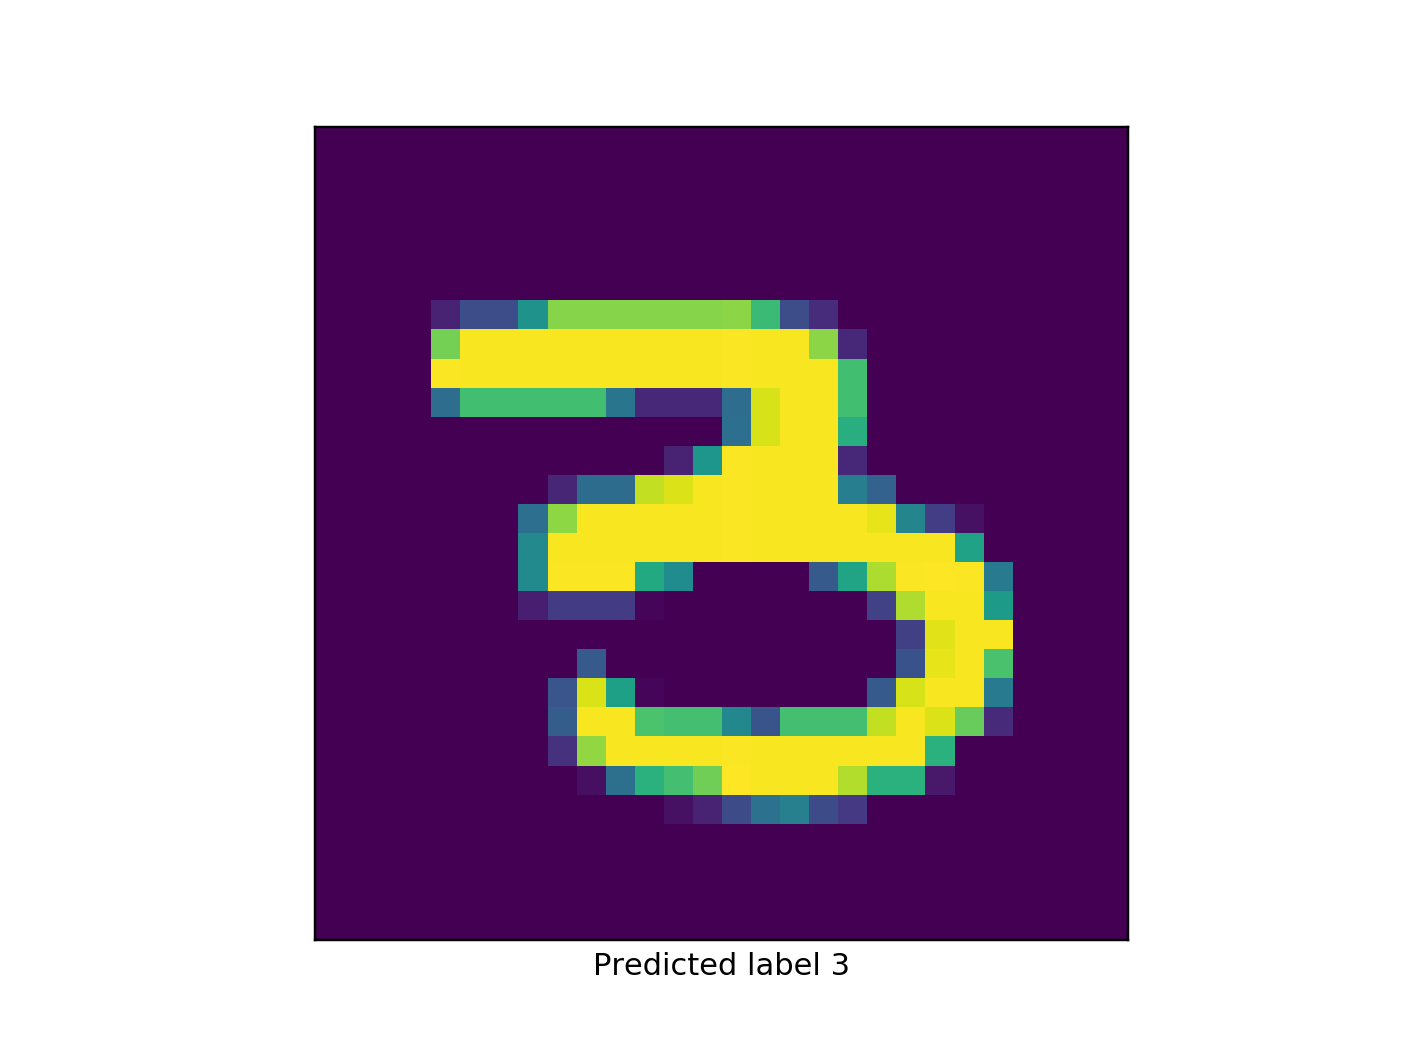

In [55]:
interact(plot_image, ind=(0,100),)